In [16]:
from classifier import *
from features import *

import cv2
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import skimage.io as io

import os
import pickle


%matplotlib inline

In [17]:
model = pickle.load(open("model.pkl",'rb'))

In [18]:
def showfaces(img,faces):
    im=np.copy(img)
    for row, col,w in faces:
        x=col*w
        y=row*w
        l=WINDOW_SIZE*w
        print(x,y,l)
        cv2.rectangle(im, (x,y),(x+l,y+l), (255,0,0),3*(w//8))
        
    io.imshow(im)

Wall time: 1.37 s


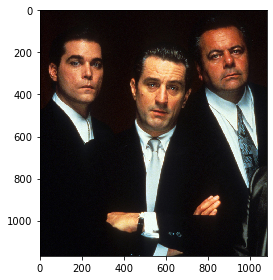

In [19]:
%%time
original_image = io.imread("1.jpg")
gray_image=rgb2gray(original_image)
    
def detect(img,model):
    
    wt=min(img.shape)//700+1
    img=cv2.resize(img,(img.shape[1]//wt,img.shape[0]//wt))
    gray=gamma(img)
    faces=[]
    Half_Window=WINDOW_SIZE//2
    for w in range(5,8,1):
        
        step=Half_Window//w+1
        sizex=gray.shape[1]//w
        sizey=gray.shape[0]//w

        target_size = (sizex, sizey)
        sizeim=cv2.resize(np.copy(gray),target_size)
        integral = to_integral(sizeim)

        rows, cols = integral.shape

        
        for row in range(0, rows - WINDOW_SIZE-2*step,3*step):
            for col in range(0, cols - WINDOW_SIZE-2*step,3*step):
                
                fr=0
                fc=0
                numf=0
                rs=[row ,row+step ,row+2*step,row ,row+step ,row+2*step,row ,row+step ,row+2*step]
                cs=[col,col,col,col+step,col+step,col+step,col+2*step,col+2*step,col+2*step]
                for i in range(9):
                    window = integral[rs[i]:rs[i]+WINDOW_SIZE+1, cs[i]:cs[i]+WINDOW_SIZE+1]
                    isf=1
                    s_h=0
                    s_a=0
                 
                    for m in model:
                        prop ,s_h, s_a=m.isFace(window,s_h,s_a)
                        if (prop<1.2):
                            isf=0
                            break
                        
                    if(isf==1):
                        numf+=1 
                        fr+=rs[i]
                        fc+=cs[i]
                        
                        
                if(numf>0):
                    fx=fr//numf
                    fy=fc//numf
                    overlabed=0
                    if (len(faces)>=3):
                        r=3
                    else:
                        r=len(faces)
                        
                    for s in range(0,r):
                        if(abs(faces[-s][0]*faces[-s][2]-fx*w*wt)+abs(faces[-s][1]*faces[-s][2]-fy*w*wt)<=9*wt*w):
                            faces[-s][0]=(faces[-s][0]*faces[-s][2]+fx*wt*w)//2
                            faces[-s][1]=(faces[-s][1]*faces[-s][2]+fy*wt*w)//2
                            faces[-s][2]=(faces[-s][2]+w*wt)//2
                            faces[-s][0]= faces[-s][0]//faces[-s][2]
                            faces[-s][1]=faces[-s][1]//faces[-s][2]
                            overlabed=1
                            break
                       
                    if(not overlabed):
                        faces.append([fx,fy,w*wt])
   
    return faces
            
faces=detect(gray_image,model)       
showfaces(original_image,faces)


In [20]:
############ try 

cap = cv2.VideoCapture(0)
faces=[]
d=2

while True:
    # grab the frame from the video stream
    ret, frame = cap.read()
    wid= (frame.shape[1]-frame.shape[0])//2
    img =cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    d=d-1
    
    if(d<0):
        faces=detect(img, model)
        d=15
        
    for (x ,y , w ) in faces:
        rectColor=(255,0,0)
        stroke=2
        row=x*w
        col=y*w
        l=w*WINDOW_SIZE
        cv2.rectangle(frame, (col,row), (col+l,row+l), rectColor,stroke)
        
 
    cv2.imshow("Frame", frame)
    if cv2.waitKey(20) &  0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()